<a href="https://colab.research.google.com/github/helen-oy/data-science-internship-hamoye/blob/main/StageE_Time_series_Hamoye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error


import seaborn as sns
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/helen-oy/data-science-internship-hamoye/89ef97b400de5ee4de9bb92e612fc17104ca24a2/Time_series_analysis_and_forecast_DATASET.csv', sep=',',dtype = float, na_values = '?',infer_datetime_format=True, parse_dates={'datetime':[0]}, index_col=['datetime']) 

In [3]:
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
datetime,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [5]:
df.shape

(92016, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92016 entries, 2010-09-01 00:00:00 to 2021-02-28 23:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tmax       92016 non-null  float64
 1   SysLoad    92016 non-null  float64
 2   GasPrice   92016 non-null  float64
 3   ElecPrice  92016 non-null  float64
dtypes: float64(4)
memory usage: 3.5 MB


In [ ]:
df.describe(include='all')

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [ ]:
df.isnull().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

In [ ]:
#Let's check for any irregularities not captured by the isna/isnull function
count_na = 0
for values in df.values.tolist():
    for value in values:
        if value == '?':
            count_na += 1
        else:
            continue
#Print the result
print('We have {} missing values not captured by isna/isnull command'.format(count_na))

We have 0 missing values not captured by isna/isnull command


In [ ]:
df.dtypes

Tmax         float64
SysLoad      float64
GasPrice     float64
ElecPrice    float64
dtype: object

In [ ]:
df2 = df.copy()
df2.head()

,Tmax,SysLoad,GasPrice,ElecPrice
datetime,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [ ]:
# Getting the pearson correlation between columns of the dataset
df2.corr (method ='pearson',min_periods=1)

,Tmax,SysLoad,GasPrice,ElecPrice
Tmax,1.000000,-0.009796,0.030173,0.002126
SysLoad,-0.009796,1.000000,-0.214574,0.138690
GasPrice,0.030173,-0.214574,1.000000,0.157768
ElecPrice,0.002126,0.138690,0.157768,1.000000


In [ ]:
# resampling daily method
daily_df = df2.resample('D').sum()
print(daily_df.shape)
daily_df.head(10)

(3834, 4)


,Tmax,SysLoad,GasPrice,ElecPrice
datetime,,,,
2010-09-01,379.2,41565.380,88.5600,2751.700
2010-09-02,369.6,38898.990,88.5600,570.810
2010-09-03,439.2,41665.760,106.8000,504.975
2010-09-04,328.8,35638.085,81.3600,502.275
2010-09-05,357.6,35611.410,106.8000,500.555
2010-09-06,350.4,42747.865,79.4400,667.190
2010-09-07,410.4,41837.245,84.2400,664.570
2010-09-08,446.4,37608.775,114.4776,490.390
2010-09-09,470.4,37351.660,82.5600,507.040


 **Augmented Dickey-Fuller Test (ADF Test) to check for stationarity in data**

In [ ]:
from statsmodels.tsa.stattools import adfuller

Writing a function that could check for stationarity and output the various columns that are stationary in the series.

In [ ]:
def adf_test(d_set):
  dftest = adfuller(d_set, autolag='AIC')
  adf = pd.Series(dftest[0:4], index = ['Test Statistics', 'p-value', '# Lags', '# Observations'])

  for key, value in dftest[4].items():
    adf['Critical Value (%s)' %key] = value
  print(adf)

  p = adf['p-value']
  if p <= 0.05:
    print("\n Series is Stationary")
  else:
    print("\n Series is Non-Stationary")


# This function takes a time series dataframe and checks the columns that are stationary.
def get_stationarity(data):
  for i in data.columns:
    print("Column: ", i)
    print('*' * 50)
    adf_test(data[i])

**# Calling the function to test for stationarity**

In [ ]:
get_stationarity(daily_df)

Column:  Tmax
**************************************************
Test Statistics          -20.766001
p-value                    0.000000
# Lags                     6.000000
# Observations          3827.000000
Critical Value (1%)       -3.432060
Critical Value (5%)       -2.862296
Critical Value (10%)      -2.567172
dtype: float64

 Series is Stationary
Column:  SysLoad
**************************************************
Test Statistics           -3.690159
p-value                    0.004254
# Lags                    30.000000
# Observations          3803.000000
Critical Value (1%)       -3.432071
Critical Value (5%)       -2.862300
Critical Value (10%)      -2.567175
dtype: float64

 Series is Stationary
Column:  GasPrice
**************************************************
Test Statistics           -2.902767
p-value                    0.045027
# Lags                    27.000000
# Observations          3806.000000
Critical Value (1%)       -3.432069
Critical Value (5%)       -2.862300
Cr

In [ ]:
# Selecting ElecPrice column for univariate time series modelling
daily_df.reset_index(inplace=True)
daily_prop = daily_df[['datetime', 'ElecPrice']]

In [ ]:
#renaming the columns
daily_prop = daily_prop.rename(columns= {'datetime': 'ds', 'ElecPrice': 'y'})
print(daily_prop.shape)
daily_prop.head()

(3834, 2)


,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


# Splitting the dataset into train and test sets respectively according to the quiz instructions
df_train = daily_prop.iloc[:2757,:]
df_test = daily_prop.iloc[2757:,:]
print(df_train.shape)
print(df_test.shape)

In [ ]:
# fbprophet modelling
# Fitting the train set to the model
from fbprophet import Prophet
model = Prophet()
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predicting the values of the test set after dropping the 'y' column
forecast = model.predict(df_test.drop(columns="y"))
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,2691.764386,206.379059,4752.030152,2691.764386,2691.764386,-155.426892,-155.426892,-155.426892,9.749221,9.749221,9.749221,-165.176114,-165.176114,-165.176114,0.0,0.0,0.0,2536.337494
1,2018-03-21,2692.580955,314.622674,5174.206412,2692.580955,2692.580955,-2.925496,-2.925496,-2.925496,159.308129,159.308129,159.308129,-162.233625,-162.233625,-162.233625,0.0,0.0,0.0,2689.655459
2,2018-03-22,2693.397524,298.176415,5074.461626,2693.397524,2693.397524,95.308217,95.308217,95.308217,257.036327,257.036327,257.036327,-161.728110,-161.728110,-161.728110,0.0,0.0,0.0,2788.705741
3,2018-03-23,2694.214093,133.159564,4794.766411,2694.214093,2694.214093,-113.236873,-113.236873,-113.236873,50.257478,50.257478,50.257478,-163.494350,-163.494350,-163.494350,0.0,0.0,0.0,2580.977221
4,2018-03-24,2695.030663,-175.051580,4918.320700,2695.030663,2695.030663,-438.662722,-438.662722,-438.662722,-271.372061,-271.372061,-271.372061,-167.290660,-167.290660,-167.290660,0.0,0.0,0.0,2256.367941


In [ ]:
# Computing the Root Mean Square Error by comparing the real values and the forecasted values
mse_prophet = mean_squared_error(df_test.y,forecast.yhat)
print ("RMSE FOR PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

RMSE FOR PROPHET 3218.16


In [ ]:
# Computing the Mean Absolute Percentage Error (mape)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = df_test['y']
pred = forecast['yhat']

mape(actual, pred)

549.4751413716547

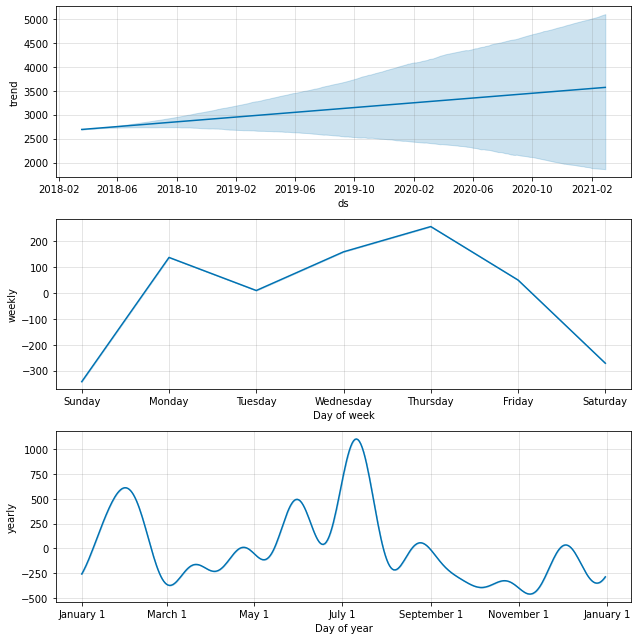

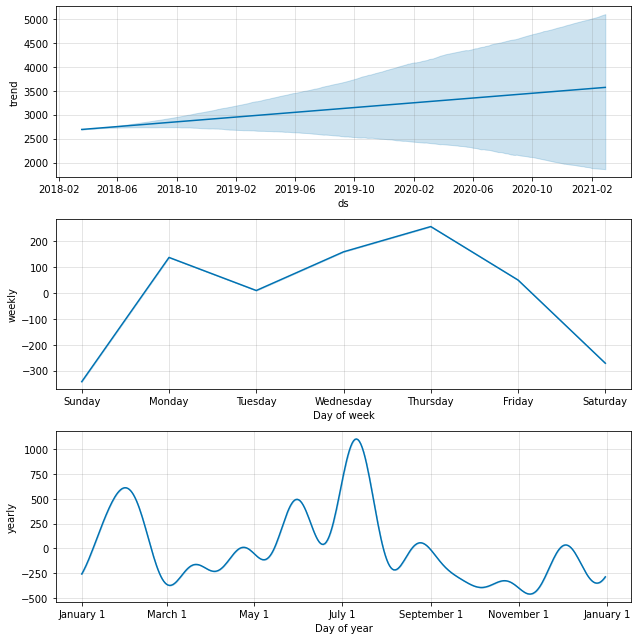

In [ ]:
# Plotting the components of the forecast
model.plot_components(forecast)

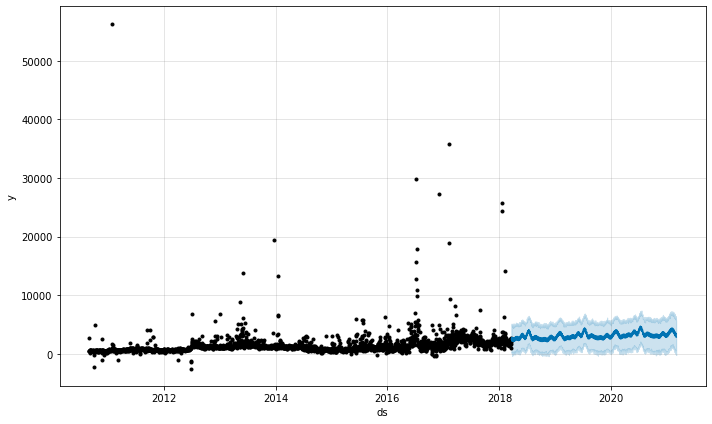

In [ ]:
# Plotting the forecasted values
model.plot(forecast)
plt.show()

### **Multivariate Time Series Forecast**

In [ ]:
# Resetting index column of the df_daily 
daily_df.reset_index(inplace = True)
multi_p = daily_df
print(multi_p.shape)
multi_p.head()

(3834, 6)


,index,datetime,Tmax,SysLoad,GasPrice,ElecPrice
0,0,2010-09-01,379.2,41565.380,88.56,2751.700
1,1,2010-09-02,369.6,38898.990,88.56,570.810
2,2,2010-09-03,439.2,41665.760,106.80,504.975
3,3,2010-09-04,328.8,35638.085,81.36,502.275
4,4,2010-09-05,357.6,35611.410,106.80,500.555


In [ ]:
multi_p = multi_p.rename(columns = {'datetime':'ds',
                                    'ElecPrice':'y',
                                    'SysLoad':'add1',
                                     'Tmax':'add2',
                                    'GasPrice':'add3'})

In [ ]:
df_train = multi_p.iloc[:2757,:]
df_test = multi_p.iloc[2757:,:]
print(df_train.shape)
print(df_test.shape)

(2757, 6)
(1077, 6)


In [ ]:
m = Prophet()
# Adding the other independent variables as regressors
m.add_regressor('add1')
m.add_regressor('add2')
m.add_regressor('add3')

# Fitting the model
m.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Predicting the test set after the 'y' column has been temporarily dropped
forecast1 = m.predict(df_test.drop(columns="y"))

In [ ]:
forecast1.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,add1,add1_lower,add1_upper,add2,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,1866.816008,-392.218199,3923.492250,1866.816008,1866.816008,-854.927934,-854.927934,-854.927934,0.232346,...,-84.367504,-84.367504,-84.367504,-38.643882,-38.643882,-38.643882,0.0,0.0,0.0,1991.737865
1,2018-03-21,1867.512671,-176.395797,4204.869631,1867.512671,1867.512671,-1024.653099,-1024.653099,-1024.653099,0.229590,...,42.497418,42.497418,42.497418,-29.294910,-29.294910,-29.294910,0.0,0.0,0.0,1983.421127
2,2018-03-22,1868.209334,707.113056,4883.089550,1868.209334,1868.209334,-214.594937,-214.594937,-214.594937,0.216232,...,145.822951,145.822951,145.822951,-24.204766,-24.204766,-24.204766,0.0,0.0,0.0,2902.578272
3,2018-03-23,1868.905997,446.006822,4879.197732,1868.905997,1868.905997,-274.431734,-274.431734,-274.431734,0.208387,...,-44.133439,-44.133439,-44.133439,-23.232775,-23.232775,-23.232775,0.0,0.0,0.0,2586.725457
4,2018-03-24,1869.602660,-858.917452,3662.139459,1869.602660,1869.602660,-1074.613585,-1074.613585,-1074.613585,0.206479,...,-117.735502,-117.735502,-117.735502,-26.128782,-26.128782,-26.128782,0.0,0.0,0.0,1440.034805


In [ ]:
# Computing the RMSE by comparing the real values and the forecasted values
mse_prophet = mean_squared_error(df_test.y,forecast1.yhat)
print ("RMSE FOR PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

RMSE FOR PROPHET 2709.65


In [ ]:
# Computing the Mean Absolute Percentage Error (mape)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = df_test['y']
pred = forecast1['yhat']

mape(actual, pred)

233.74494702819595

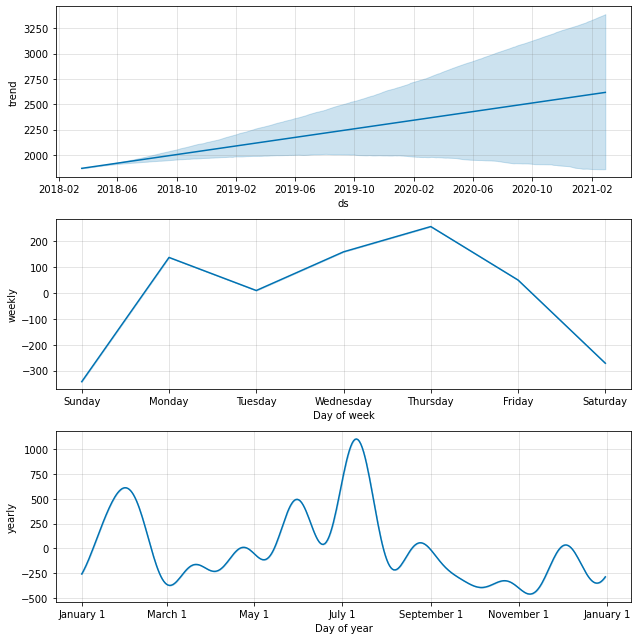

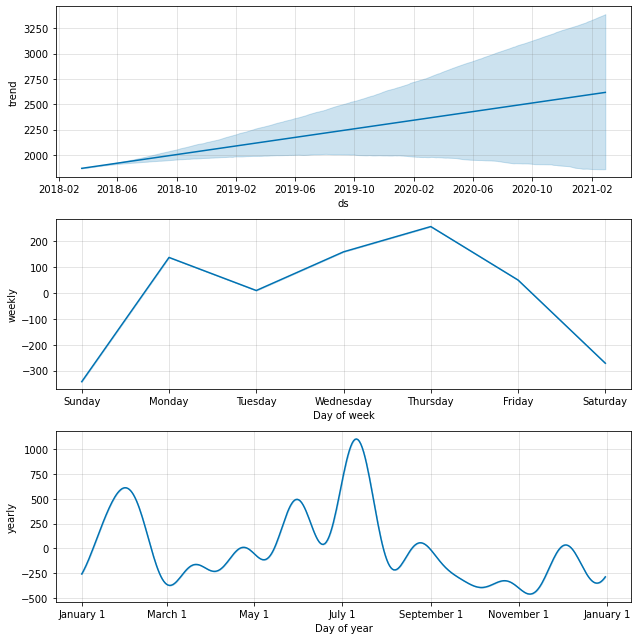

In [ ]:
# Plotting the components of the multivariate forecast
model.plot_components(forecast1)